# Assignment 5: "No one can be told what the Ranktrix is. You have to see it for yourself."

## © Cristian Danescu-Niculescu-Mizil 2018

## CS/INFO 4300 Language and Information

### Due by midnight on Wednesday March 7th

**Guidelines**

For code completion tasks, just type your code after the comment marking the place.  For questions, use as many notebook cells as needed to compute intermediate stuff. All floating point values should be printed with 2 decimal places precision.

You are strongly encouraged to write sensible **test cases** for your code.

This is an **individual** assignment.

If you use any outside sources (e.g. research papers, StackOverflow) please list your sources.

In this assignment we will explore evaluation of an information retrevial system where both queries and results are movies. Ever wanted to know what the most similar movie to "The Matrix" is, in terms of language? Now is your chance! You take the blue pill - the story ends, you wake up in your dorm on west campus and believe whatever you want to believe. You take the red pill - you stay in CS/INFO 4300 and we show you how deep the rabbit-hole goes.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

## Introduction
In this assignment, we will be building a system that allows for you to query for movies similar to a given movie. Unlike before, queries and information retrieved have the same type -- i.e. movies are *both* queries and results. To accomplish this task, we will utilize a dataset of movies and their transcripts. We will begin by using the language contained in the transcripts to do basic queries. We will continue to use the vector space model, encoding "documents" (here, a document is a movie script) as tf-idf vectors.

In [1]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from numpy import linalg as LA
import json
%matplotlib inline
import matplotlib.pyplot as plt

## Using sklearn to get tf-idf vectors
On the last assignment, we used an inverted index to quickly compute queries by taking advantage of the sparsity of tf-idf vectors in our vector space. However, the dataset we are considering for this assignment is small enough such that we can use explicit vectors, rather than an inverted index, to compute cosine similarities. We also will not be implementing tf-idf by hand -- we will be using an existing implementation from the library [sklearn,](http://scikit-learn.org/stable/) which provides a lot of good implementations of machine learning algorithms in python. We will be making heavy use of this powerful library in later assignments, so using it to extract tfidf features is a good starting point!

In [2]:
with open("movie_scripts_data.json") as f:
    data = json.loads(f.readlines()[0])
num_movies = len(data)
print("Loaded {} movie transcripts".format(num_movies))
print("Each movie transcript is a dictionary with the following keys...")
print(data[0].keys())

# Here, we will assign an index for each movie_id. This index will help us access data in numpy matrices.
movie_id_to_index = {movie_id:index for index, movie_id in enumerate([d['movie_id'] for d in data])}

# We will also need a dictionary maping movie names to movie ids
movie_name_to_id = {name:mid for name, mid in zip([d['movie_name'] for d in data],
                                                     [d['movie_id'] for d in data])}
movie_id_to_name = {v:k for k,v in movie_name_to_id.items()}

# and because it might be useful...
movie_name_to_index = {name:movie_id_to_index[movie_name_to_id[name]] for name in [d['movie_name'] for d in data]}
movie_index_to_name = {v:k for k,v in movie_name_to_index.items()}

print("The index of \"{}\" is {}".format(data[7]['movie_name'], movie_id_to_index[data[7]['movie_id']]))

Loaded 617 movie transcripts
Each movie transcript is a dictionary with the following keys...
dict_keys(['movie_name', 'script', 'movie_id', 'categories'])
The index of "spare me" is 7


We can see that each movie is assigned an "index" (from 0 to 616). These will correspond to the rows of a document-by-tfidf score matrix.

## Question 1 (Code Completion): TFIDF Vectorizer
Read up on sklearn's [tfidf-vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This function takes in a list of documents and some parameters related to parsing and outputs a document-by-vocabulary matrix, where entry i,j corresponds to the tfidf score of word j in document i. Your first job is to make a TfidfVectorizer object that includes the following preprocessing properties: it only considers words that appear at least ten times, but in no more than 80% of all documents. Also, it computes a maximum of 5000 features, and doesn't include english stopwords. Finally, it should normalize all tfidf vectors to have an l2 norm of one.

Once you've made this object, call it's fit_transform() function on the list of *scripts* (not titles) in data. This should produce a numpy matrix whose shape is the number of documents by the number of words you're considering (which has a maximum of 5000).

In [3]:
n_feats = 5000
doc_by_vocab = np.empty([len(data), n_feats])

def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm='l2'):
    """Returns a TfidfVectorizer object
    
    Params: {max_features: Integer,
             max_df: Float,
             min_df: Float,
             norm: String,
             stop_words: String}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    return TfidfVectorizer(max_features = max_features, stop_words = stop_words, max_df = max_df, \
                          min_df = min_df, norm = norm)
    raise NotImplementedError()
    
tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform([d['script'] for d in data]).toarray()
index_to_vocab = {i:v for i, v in enumerate(tfidf_vec.get_feature_names())}

/home/bowen/Desktop/assignment5/venv/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [4]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_vectorizer returns the correct output"""
assert type(doc_by_vocab) == np.ndarray
assert type(tfidf_vec) == TfidfVectorizer
assert sum(doc_by_vocab[2,:]) < 20
assert doc_by_vocab.shape == (617, 5000)
assert 'zoo' in index_to_vocab.values()

## Question 2 (Code Completion): Cosine Similarity
You will implement the function below which takes in the names of two movies and returns the cosine similarity of those two movie transcripts.

In [5]:
def get_sim(mov1, mov2, input_doc_mat, movie_name_to_index):
    """Returns a float giving the cosine similarity of 
       the two movie transcripts.
    
    Params: {mov1: String,
             mov2: String,
             input_doc_mat: Numpy Array,
             movie_name_to_index: Dict}
    Returns: Float (Cosine similarity of the two movie transcripts.)
    """
    # YOUR CODE HERE
    idx1 = movie_name_to_index[mov1]
    idx2 = movie_name_to_index[mov2]
    numerator = np.dot(input_doc_mat[idx1], input_doc_mat[idx2])
    denominator = np.sqrt(np.sum(np.square(input_doc_mat[idx1])))*\
                    np.sqrt(np.sum(np.square(input_doc_mat[idx2])))
    return numerator/denominator
    raise NotImplementedError()

In [6]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that get_sim returns the correct output"""
print("Similarity: Star Wars vs. Jurassic Park")
print("======")
test1 = get_sim('star wars', 'jurassic park', doc_by_vocab, movie_name_to_index)
print(test1)
assert test1 < 0.07 and test1 > 0.04
print("")

print("Similarity: Star Wars vs. Star Trek: Generations")
print("======")
test2 = get_sim('star wars', 'star trek: generations', doc_by_vocab, movie_name_to_index)
print(test2)
assert test2 < 0.25 and test2 > 0.20


Similarity: Star Wars vs. Jurassic Park
0.06579339531549762

Similarity: Star Wars vs. Star Trek: Generations
0.21443120458852555


## Question 3 (Code Completion): Term Similarity
Complete the function top_terms, which takes in the names of two movies, and returns the top matching tfidf terms from those two movie transcripts. Consider doing an element-wise product of the two movies' tfidf vectors. If both vectors have a high value for a particular term, then it is contributing to the cosine similarity for each (e.g. if both "star wars" and "jurassic park" both had high tfidf weights for "fight," then this word would likely be a top_term for the two). After performing the element-wise product, find the indices that produce the highest values.

In [7]:
def top_terms(mov1,mov2, input_doc_mat, index_to_vocab, movie_name_to_index, top_k=10):
    """Returns a list of the top k similar terms between the
        two movie transcripts.
    
    Params: {mov1: String,
             mov2: String,
             input_doc_mat: Numpy Array,
             movie_name_to_index: Dict,
             top_k:Int}
    Returns: List 
    """
    # YOUR CODE HERE
    idx1 = movie_name_to_index[mov1]
    idx2 = movie_name_to_index[mov2]
    product = np.multiply(input_doc_mat[idx1], input_doc_mat[idx2])
    idx_to_product = list(zip(range(len(product)), product))
    sorted_ = sorted(idx_to_product, key = lambda x: x[1], reverse = True)[:top_k]
    term_idx, _ = zip(*sorted_)
    return [index_to_vocab[idx] for idx in term_idx]
    raise NotImplementedError()

In [8]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that get_sim returns the correct output"""
print("Top ten terms between: Star Wars and Jurassic Park")
print("======")
term_test_1 = top_terms('star wars', 'jurassic park', doc_by_vocab, index_to_vocab, movie_name_to_index)
for term in term_test_1:
    print(term)
assert 'force' in term_test_1

print("")
print("Top ten terms between: Star Wars and Star Trek: Generations")
term_test_2 = top_terms('star wars', 'star trek: generations', doc_by_vocab,index_to_vocab, movie_name_to_index)
assert 'star' in term_test_2
print("======")
for term in term_test_2:
    print(term)


Top ten terms between: Star Wars and Jurassic Park
power
force
use
control
procedures
afraid
major
gear
guarantee
thousand

Top ten terms between: Star Wars and Star Trek: Generations
data
sir
ship
star
captain
energy
information
starfleet
weapon
power


## Question 4 (Code Completion): Similar Transcripts, Similar Movies w/ Cosine Sim

Given your get_sim function, you can now compute how similar movies are to one another! Here, we will first precompute the distance between every possible pair of movies, and store it in a movies-by-movies matrix. Given this matrix, for a given movie, it is possible to produce a ranking of how similar all other movies are to the given movie. For instance, we will see what movies are the most similar and dissimilar to star wars.

In [9]:
def build_movie_sims_cos(n_mov,movie_index_to_name,input_doc_mat,movie_name_to_index,input_get_sim_method):
    """Returns a movie_sims matrix of size (num_movies,num_movies) where for (i,j):
        [i,j] should be the cosine similarity between the movie with index i and the movie with index j
        
    Note: What you set the diagonal to doesn't really matter, 
    but you should set it to 1 to indicate that all movies are trivially perfectly similar to themselves.
    
    Params: {n_mov: Integer,
             movie_index_to_name: String,
             input_doc_mat: Numpy Array,
             movie_name_to_index: Dict,
             input_get_sim_method: Function}
    Returns: Numpy Array 
    """
    # YOUR CODE HERE
    mov_mov_mat = np.ones((n_mov, n_mov))
    for i in range(0, n_mov):
        for j in range(i+1, n_mov):
            mov_mov_mat[i][j] = mov_mov_mat[j][i] \
            = input_get_sim_method(movie_index_to_name[i], movie_index_to_name[j], \
                                    input_doc_mat, movie_name_to_index)
    return mov_mov_mat
    raise NotImplementedError()

In [10]:
movie_sims_cos = build_movie_sims_cos(num_movies, movie_index_to_name, doc_by_vocab, movie_name_to_index, get_sim)

In [11]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_movie_sims_cos returns the correct output"""
assert type(movie_sims_cos) == np.ndarray
assert movie_sims_cos.shape == (617,617)
assert sum(movie_sims_cos[:,5]) > 40

## Question 4b (Code Completion): Similar Transcripts, Similar Movies w/ Jaccard Sim

For a baseline comparison, we will also consider the similarity between movies in terms of categories. Specifically, you'll notice that each movie is associated with a list of categories. One could ignore the transcripts *entirely* and say that the similarity between any two movies is the jaccard similarity of their category sets. While this is a very rough way to measure similarity, we will use it as a baseline for comparison with the linguistic methods. 

In [12]:
def build_movie_sims_jac(n_mov,input_data):
    """Returns a movie_sims_jac matrix of size (num_movies,num_movies) where for (i,j) :
        [i,j] should be the jaccard similarity between the category sets for movies i and j
        such that movie_sims_jac[i,j] = movie_sims_jac[j,i]. 
        
    Note: Movies sometimes contain *duplicate* categories! You should only count a category once
    
    Params: {n_mov: Integer,
             input_data: List<Dictionary>}
    Returns: Numpy Array 
    """
    # YOUR CODE HERE
    jac_sim_mat = np.ones((n_mov, n_mov))
    for i in range(0, n_mov):
        for j in range(i+1, n_mov):
            set_i = set(input_data[i]['categories'])
            set_j = set(input_data[j]['categories'])
            jac_sim_ij = (len(set_i.intersection(set_j))+0.)/len(set_i.union(set_j))
            jac_sim_mat[i][j] = jac_sim_mat[j][i] = jac_sim_ij
    return jac_sim_mat
    raise NotImplementedError()

In [13]:
movie_sims_jac = build_movie_sims_jac(num_movies,data)

In [14]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_movie_sims_cos returns the correct output"""
assert type(movie_sims_jac) == np.ndarray
assert movie_sims_jac.shape == (617,617)
assert sum(movie_sims_jac[:,5]) > 60 and sum(movie_sims_jac[:,5]) < 70

## Question 4c (Free Response): Similar Transcripts, Similar Movies

Using the movie_sims_cos and movie_sims_jac matrix you computed, we are now going to compare cosine vs. jaccard similarity by printing the 10 most similar (ignoring itself) and 10 most dissimilar movies to 'star wars'.

In [15]:
def get_ranked_movies(mov, matrix):
    """
    Return sorted rankings (most to least similar) of movies as 
    a list of two-element tuples, where the first element is the 
    movie name and the second element is the similarity score
    
    Params: {mov: String,
             matrix: np.ndarray}
    Returns: List<Tuple>
    """
    
    # Get movie index from movie name
    mov_idx = movie_name_to_index[mov]
    
    # Get list of similarity scores for movie
    score_lst = matrix[mov_idx]
    mov_score_lst = [(movie_index_to_name[i], s) for i,s in enumerate(score_lst)]
    
    # Do not account for movie itself in ranking
    mov_score_lst = mov_score_lst[:mov_idx] + mov_score_lst[mov_idx+1:]
    
    # Sort rankings by score
    mov_score_lst = sorted(mov_score_lst, key=lambda x: -x[1])
    
    return mov_score_lst


def print_top(mov, matrix, sim_type, k=10):
    """
    Print the k most and least similar movies to 'star wars'
    
    Params: {mov: String,
             matrix: np.ndarray,
             sim_type: String,
             k: Integer}
    Returns: None
    """
    
    mov_score_lst = get_ranked_movies(mov, matrix)
    
    print("Top {} most similar movies to {} [{}]".format(k, 'star wars', sim_type))
    print("======")
    for (mov, score) in mov_score_lst[:k]:
        print("%.3f %s" % (score, mov))

    print()
    
    print("Top {} least similar movies to {} [{}]".format(k, 'star wars', sim_type))
    print("======")
    for (mov, score) in mov_score_lst[-k:][::-1]:
        print("%.3f %s" % (score, mov))

In [16]:
print_top('star wars', movie_sims_cos, 'cosine sim')

Top 10 most similar movies to star wars [cosine sim]
0.468 star wars: the empire strikes back
0.406 star wars: episode vi - return of the jedi
0.252 cool hand luke
0.246 star trek: nemesis
0.214 star trek: generations
0.214 star trek: first contact
0.211 the majestic
0.205 star trek: insurrection
0.203 hannibal
0.197 dr. strangelove or: how i learned to stop worrying and love the bomb

Top 10 least similar movies to star wars [cosine sim]
0.004 what women want
0.010 the jazz singer
0.013 the deer hunter
0.014 five feet high and rising
0.014 the rocky horror picture show
0.015 the negotiator
0.019 beavis and butt-head do america
0.026 shock treatment
0.027 spare me
0.027 serial mom


In [17]:
print_top('star wars', movie_sims_jac, 'jaccard')

Top 10 most similar movies to star wars [jaccard]
1.000 krull
1.000 the fantastic four
1.000 fantastic four
1.000 star wars: episode vi - return of the jedi
0.800 superman ii
0.800 superman iv: the quest for peace
0.800 spider-man
0.800 superman iii
0.800 jurassic park
0.800 ghostbusters ii

Top 10 least similar movies to star wars [jaccard]
0.000 all the president's men
0.000 all about eve
0.000 grand hotel
0.000 the grifters
0.000 the graduate
0.000 get shorty
0.000 ghost ship
0.000 ghost world
0.000 storytelling
0.000 dr. strangelove or: how i learned to stop worrying and love the bomb


**In the cell below, analyze the most similar and least similar results above for both cosine similarity and jaccard similarity. Please comment on how well (or poorly) you think both of the similarity measures performed. Do these results make sense to you, and why?**

Since we used categories rather than transcripts when computing jaccard similarity, the results above for jaccard similarity is obviously poorer than those for cosine similarity. Cosine sim managed to find all "star wars" movies and listed them on the top. In addition, it also accurately found other similar sci-fi movies such as "star trek". Jaccard sim did poorly also in finding the least similar movies all the top 10 movies has score 0, which are not very informative for us.

## Question 5 (Code Completion): Evaluating our rankings with precision-recall curves

Given that we are able to produce a most-to-least similar ranking of all other movies given all other movies, we can now ask the question: "how good are our rankings?" For this part, we will be using the following (query, [related movie list]) pairs for you to evaluate against. We will treat these as ground truth. More generally, you could imagine that these "ground truths" result from aggregated user feedback from a movie recomendation system like Netflix.

In [18]:
queries = [('the matrix', ['the bourne supremacy',
                           'being john malkovich',
                           'smoke',
                           'erin brockovich',
                           'an officer and a gentleman',
                           'smokin\' aces',
                           'pitch black',
                           'out of sight',
                           'clerks.',
                           'xxx',
                           'the x files',
                          ]),
           ('star wars',  ['star wars: the empire strikes back',
                            'star wars: episode vi - return of the jedi',
                            'indiana jones and the last crusade',
                            'indiana jones and the temple of doom',
                            'jurassic park',
                            'the lost world: jurassic park',
                            'jurassic park iii',
                            'star trek v: the final frontier',
                            'star trek: the motion picture',
                            'star trek: first contact',
                            'star trek vi: the undiscovered country',
                            'star trek iv: the voyage home',
                            'the majestic',
                            'hannibal',
                            'star trek: insurrection',
                            'dr. strangelove or: how i learned to stop worrying and love the bomb'
                          ]),
          ('a nightmare on elm street', ['a nightmare on elm street part 2: freddy\'s revenge',
                                         'a nightmare on elm street: the dream child',
                                         'cruel intentions',
                                         'erin brockovich',
                                         'hellraiser: hellseeker',
                                         'little nicky',
                                        ]),]

We will use two evaluation metrics: precision vs. recall plots and a statistic called mean average precision. To start off, **complete the function precision_recall function below.**

In [19]:
def precision_recall(ranking_in, relevant):
    '''
    Returns lists of precision and recall at different k values
    
    Param info:
        ranking_in: sorted ranking of movies, starting with the most most similar, and ending
        with the least similar.
        
        relevant: iterable of movies relevant to the original query
        
    Return info:
        precision: list of length equal to the length+1 of ranking_in, where precision[k] = the
        precision@k. Leave precision[0] to be 0.
        
        recall: list of length equal to the length+1 of ranking_in, where recall[k] = the
        recall@k. Leave recall[0] to be 0.
        
    Params: {ranking_in: String,
             relevant: String List}
    Returns: {precision: np.ndarray,
              recall: np.ndarray}
    '''
    # YOUR CODE HERE
    precision = np.zeros(len(ranking_in)+1)
    recall = np.zeros(len(ranking_in)+1)
    n_rel = len(relevant)
    for k in range(1, len(precision)):
        n_rel_ret = len([mov for mov in ranking_in[:k] if mov in relevant])
        precision[k] = n_rel_ret/(k+0.)
        recall[k] = n_rel_ret/(n_rel+0.)
    return precision, recall
    raise NotImplementedError()

In [20]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that precision_recall returns the correct output"""
query, rel_movs = queries[1]
ranked_movs = [m for m,_ in get_ranked_movies(query, movie_sims_cos)]
precision, recall = precision_recall(ranked_movs, rel_movs)

assert precision[0] == 0
assert recall[0] == 0
assert precision.shape == (617,)
assert recall.shape == (617,)
assert sum(precision) > 48 and sum(precision) < 54
assert sum(recall) > 505 and sum(recall) < 511
assert precision[300] > 0.04 and precision[300] < 0.05
assert recall[300] > 0.8 and recall[300] < 0.9


## Plotting Precision-Recall Curves

Below, we have provided the code that uses matplotlib to create a recall (x-axis) vs. precision (y-axis) plot, plotting each of the 3 ground truth queries as seperate lines on the plot. For each query, we consider all N-1 movies other than the query itself when computing the ranking. The label of each line is the ground truth query. 

It's worth noting that considering precision/recall curves like this on the query level is a bit odd. In general, given more supervised data, one would compute aggregate precision/recall curves over a large number of ground truths. In this way, each line would represent a different information retrevial algorithm's performance over the test set of queries. However, we will be somewhat unorthodox here and plot one curve per query.

In [21]:
def plot_precision_recall(matrix, xlim, ylim):
    """Plots the precision-recall curve given the similarity matrix
    
    Params: {matrix: np.ndarray,
             xlim: List,
             ylim: List}
    Returns: None
    """
    for query, rel_movs in queries:
        ranked_movs = [m for m,_ in get_ranked_movies(query, matrix)]
        precision, recall = precision_recall(ranked_movs, rel_movs)
        plt.plot(recall, precision)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend([q[0] for q in queries])

## Question 5b (Free Response): Cosine Similarity Plot Analysis

Run the code below to show the precision-recall curve for our three movie queries using cosine similarity. 

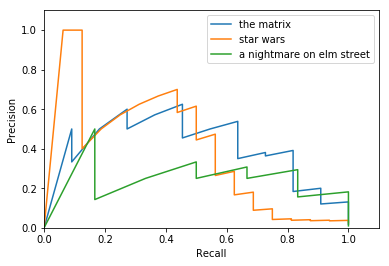

In [22]:
# Cosine Similarity Plot
plot_precision_recall(movie_sims_cos, [0,1.1], [0,1.1])

**Looking at the cosine similarity plot above, make some observations about why you're seeing what you're seeing. Include a brief description of what went well, what went wrong, and how you know.**

As we can see from the plot that for each of the three movie queries, precision is basically negatively related to recall. But there are several exceptional points including zero. That's because we set the first element of precision and recall to be zero. There is a negative relationship because the maximum of relevant docs is fixed, and thus precision will decrease as the number of retrieved docs increases. On the other hand, recall will increase to 1 as retrieved docs increase.

## Question 5c (Free Response): Jaccard Similarity Plot Analysis

Run the code below to show the precision-recall curve for our three movie queries using jaccard similarity. 

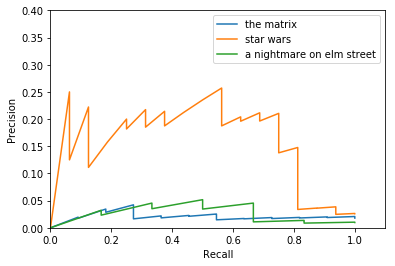

In [23]:
# Jaccard Similarity Plot
plot_precision_recall(movie_sims_jac, [0,1.1], [0,0.4])

**Looking at the jaccard similarity plot above,  make some observations about why you're seeing what you're seeing. Include a brief description of what went well, what went wrong, and how you know.**

The plot above shows that for jaccard similarity, the relationship between precision and recall is basically the same and recall also grows from 0 to 1 in this case. But an abvious difference is that precision this time is much lower especially for "the matrix" and "a nightmare on elm street". That's because Jaccard similarity use categories to compute similarity which is too rough for this problem.

## Question 5d (Free Response): Cosine Sim vs Jaccard Sim Plot Comparison

**Now that you've observed the plots for both cosine similarity and jaccard similarity, please answer the following two questions:**

**1. Which system performs better, in general?**  
**2. Which query was the most problematic in each case?**

1. Cosine similarity is better.
2. "A nightmare on elm street" in cosine similarity system and "the matrix" in Jaccard similarity system.

## Evaluating our rankings with mean average precision

While precision/recall curves are a good tool to visualize how well our rankings are performing, in some contexts, it is ideal to come up with a single number that characterizes how well our ranking system is doing over all ground-truth queries. A commonly used statistic for ranking systems is mean average precision. To compute this value, first, one must compute the average precision for each query and subsequent ranking output by the system. Next, one averages these values. We've filled in functions for both average_precision and mean_average_precision for you. At the end of this section, run the provided code, which will give you a single number that evaluates the performance of each ranking system.

In [24]:
def average_precision(ranking_in, relevant):
    '''
    Arguments:
        ranking_in: sorted ranking of movies, starting with the most most similar, and ending
        with the least similar.
        
        relevant: iterable of movies relevant to the original query
        
    Returns:
        average_precision: float corresponding to the AP statistic for this ranking and
        this set of relevant docuemnts.
    '''
    rel_rank = sorted([ranking_in.index(r)+1 for r in relevant])
    return np.mean([(i+1)*1./(r) for i, r in enumerate(rel_rank)])
    
    
def mean_average_precision(queries_in, sims_mat):
    '''
    Arguments:
        queries_in: a list of (query, [relevant documents]) pairs, representing the queries we
        want to evaluate our ranking system against
    
        sims_mat: a movie by movie numpy array, where sims_mat[i,j] = sims_mat[j,i] = the similarity
        of movies i and j
    
    Returns:
        mean_average_precision: float corresponding to the average AP statistic for the input queries
        and the similarity matrix
    '''
    rankings = [[movie_index_to_name[i] for i in np.argsort(sims_mat[movie_name_to_index[q],:])[::-1]]
                for q,_ in queries]
    for q, rank in zip([q[0] for q in queries_in], rankings):
        print(q)
        print("======")
        for r in rank[:10]: print(r)
        print()
    
    
    return np.mean([average_precision([movie_index_to_name[i]
                    for i in np.argsort(sims_mat[movie_name_to_index[q],:])[::-1]], true)
                    for q, true in queries])

In [25]:
print("Text with tfidf features: {:.3f}".format(mean_average_precision(queries, movie_sims_cos)))
print("\n~\n")
print("Jaccard similarities: {:.3f}".format(mean_average_precision(queries, movie_sims_jac)))

the matrix
the matrix
metropolis
xxx
fear and loathing in las vegas
the x files
smokin' aces
made
an officer and a gentleman
being john malkovich
cellular

star wars
star wars
star wars: the empire strikes back
star wars: episode vi - return of the jedi
cool hand luke
star trek: nemesis
star trek: generations
star trek: first contact
the majestic
star trek: insurrection
hannibal

a nightmare on elm street
a nightmare on elm street
a nightmare on elm street 3: dream warriors
a nightmare on elm street part 2: freddy's revenge
jerry maguire
new nightmare
drop dead gorgeous
cherry falls
monkeybone
hellraiser: hellseeker
little nicky

Text with tfidf features: 0.336

~

the matrix
dune
the matrix
alien vs. predator
supergirl
the time machine
star trek: the wrath of khan
jurassic park iii
escape from l.a.
independence day
star trek: insurrection

star wars
star wars
the fantastic four
star wars: episode vi - return of the jedi
krull
fantastic four
superman iii
ghostbusters ii
superman iv: th

## Rocchio Algorithm

Great -- we have a baseline evaluation for how well our vector space tfidf information retrevial system does! Now, it is our job to do something better. Here, we will implement the Roccio Algorithm and use it for pseduo relevance feedback.

This is Rocchio’s query update rule for relevance feedback:

$$\overrightarrow{{q}_1} = a * \overrightarrow{{q}_0} + b*\frac{1}{|D_r|}\sum_{d \in D_r}{\overrightarrow{d}}-g*\frac{1}{|D_{nr}|}\sum_{d \in D_{nr}}{\overrightarrow{d}}$$ 

In the above, $\overrightarrow{{q}_0}$ is the initial query, $\overrightarrow{{q}_1}$ is the updated query, $D_r$ is the set of relevant documents and $D_{nr}$ is the set of non-relevant documents. If, after the update, there are negative weights in $\overrightarrow{{q}_1}$, they are set to 0.

## Question 6 (Code Completion): Rocchio
Your job here is to implement the Rocchio Algorithm for relevance feedback. This function will test your understanding of how numpy arrays interact with variable types. For example, a + b where a is a python float and b is a numpy array will return a numpy array where each element of b has been shifted by a. While this particular function may or may not be needed to implement rocchio, it can be *very* helpful. 

In [26]:
def rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index,a=.3, b=.3, c=.8, clip = True):
    """Returns a vector representing the modified query vector. 
    
    Note: 
        The resulting vector should have no negatve weights in it!
        Be sure to handle the cases where relevant and irrelevant are empty lists.
        
    Params: {query: String (the name of the movie being queried for),
             relevant: List (the names of relevant movies for query),
             irrelevant: List (the names of irrelevant movies for query),
             input_doc_matrix: Numpy Array,
             movie_name_to_index: Dict,
             a,b,c: floats (weighting of the original query, relevant queries,
                             and irrelevant queries, respectively),
             clip: Boolean (whether or not to clip all returned negative values to 0)}
    Returns: Numpy Array 
    """
    # YOUR CODE HERE
    query_idx = movie_name_to_index[query]
    q0 = input_doc_matrix[query_idx]
    irrel_idx = [movie_name_to_index[mname] for mname in irrelevant]
    sum_irrel = np.sum(input_doc_matrix[irrel_idx,], axis = 0)
    if len(relevant) != 0:
        rel_idx = [movie_name_to_index[mname] for mname in relevant]
        sum_rel = np.sum(input_doc_matrix[rel_idx,], axis = 0)
        q1 = a*q0 + b/len(relevant)*sum_rel - c/len(irrelevant)*sum_irrel
    else:
        q1 = a*q0 - c/len(irrelevant)*sum_irrel
    if clip == True:
        q1[q1 < 0] = 0.
        return q1
    else:
        return q1
    raise NotImplementedError()

Before we use the Rocchio algorithm for understanding pseduo-relevance feedback, we'll do a reality check and make sure that our implementation can improve performance on our existing queries. To augment our analysis, movie guru Ilan has also provided you with a list of irrelevant queries for each of our test queries. You'll notice that the irrelevant queries for each of the test queries are quite similar. This is because it's much more common for a pair of movies to be irrelevant, rather than relevant. In fact, it's not uncommon that *all* queries that are not relevant are *assumed to be irrelevant.*

Here, though, we'll just use this small subset.

In [27]:
irrelevant  = [('the matrix', ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                              'suburbia',
                               'taking sides',
                               'lake placid'
                              ]),
               ('star wars',  ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                              'suburbia',
                              'taking sides',
                              'lake placid']),
               ('a nightmare on elm street', ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                                'suburbia',
                                'taking sides',
                                'lake placid']),]


In [28]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that rocchio returns the correct output"""
query_vector = rocchio("the matrix",[],irrelevant[0][1],doc_by_vocab,movie_name_to_index)
query_vector2 = rocchio("star wars",[],irrelevant[1][1],doc_by_vocab,movie_name_to_index)
assert type(query_vector) == np.ndarray
assert type(query_vector2) == np.ndarray
assert sum(query_vector) > 3 and sum(query_vector) < 4
assert sum(query_vector2) > 2 and sum(query_vector2) < 3

## Question 7 (Code Completion): Leveraging Rocchio
Your job is to leverage rocchio to return the top 10 highest ranked movies for each query, with rocchio. 
Return the dictionary with in the following format:
```
{'the matrix': [movie1,movie2,...,movie10],
 'star wars': [movie1,movie2,...,movie10],
 'a nightmare on elm street': [movie1,movie2,...,movie10]}
```

In [29]:
def top_10_with_rocchio(relevant_in, irrelevant_in, input_doc_matrix, \
            movie_name_to_index,movie_index_to_name,input_rocchio):
    """Returns a dictionary in the following format:
    {
        'the matrix': [movie1,movie2,...,movie10],
         'star wars': [movie1,movie2,...,movie10],
         'a nightmare on elm street': [movie1,movie2,...,movie10]
    }
    
    Note: 
        You can assume that relevant_in[i][0] = irrelevant_in[i][0] 
        (i.e. the queries are in the same order). 
        You should use the default rocchio parameters.
        
    Params: {relevant_in: List ((query, [relevant documents]) pairs, representing 
                                the queries we want to evaluate our ranking system 
                                against,along with some relevant documents),
             irrelevant_in: List ((query, [irrelevant documents]) pairs, representing 
                                 the queries we want to evaluate our ranking system 
                                 against, along with some irrelevant documents),
             input_doc_matrix: Numpy Array,
             movie_name_to_index: Dict,
             movie_index_to_name: Dict,
             input_rocchio: Function}
    
    Returns: Dict 
    """
    # YOUR CODE HERE
    result = {}
    for i in range(len(relevant_in)):
        query = relevant_in[i][0]
        relevant = relevant_in[i][1]
        irrelevant = irrelevant_in[i][1]
        q1 = input_rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index)
        mov_idx = movie_name_to_index[query]
        score_list = []
        for doc in input_doc_matrix:
            numerator = np.dot(q1, doc)
            denominator = np.sqrt(np.sum(np.square(q1)))*np.sqrt(np.sum(np.square(doc)))
            score_list.append(numerator/denominator)
        mov_score_lst = [(movie_index_to_name[i], s) for i,s in enumerate(score_list)]
        mov_score_lst = mov_score_lst[:mov_idx] + mov_score_lst[mov_idx+1:]
        mov_score_lst_top10 = sorted(mov_score_lst, key=lambda x: -x[1])[:10]
        mov_top_10, _ = zip(*mov_score_lst_top10)
        result[query] = list(mov_top_10)
    return result
    raise NotImplementedError()

In [30]:
movie_recommend_with_rocchio = top_10_with_rocchio(queries, irrelevant,\
                                                  doc_by_vocab,movie_name_to_index,\
                                                  movie_index_to_name,rocchio)
for k,v in movie_recommend_with_rocchio.items():
    print(k)
    print("="*len(k))
    [print(a) for a in v]
    print("")

the matrix
the x files
xxx
smokin' aces
metropolis
pitch black
suspect zero
fear and loathing in las vegas
an officer and a gentleman
clerks.
out of sight

a nightmare on elm street
a nightmare on elm street 3: dream warriors
a nightmare on elm street part 2: freddy's revenge
a nightmare on elm street: the dream child
new nightmare
hellraiser: hellseeker
jerry maguire
little nicky
cherry falls
cruel intentions
drop dead gorgeous

star wars
star wars: the empire strikes back
star wars: episode vi - return of the jedi
star trek: nemesis
star trek: first contact
star trek: generations
star trek: insurrection
cool hand luke
star trek vi: the undiscovered country
star trek: the motion picture
star trek v: the final frontier



In [31]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that top_10_with_rocchio returns the correct output"""
assert type(movie_recommend_with_rocchio) == dict
assert "the x files" in movie_recommend_with_rocchio["the matrix"]
assert "star wars: the empire strikes back" in movie_recommend_with_rocchio["star wars"]
assert "a nightmare on elm street 3: dream warriors" in \
    movie_recommend_with_rocchio["a nightmare on elm street"]

## Question 7b (Code Completion): Leveraging Rocchio
Your job is to implement mean_average_precision_rocchio below.

Your function should call rocchio and average_precision. 

In [32]:
def mean_average_precision_rocchio(relevant_in, irrelevant_in, input_doc_matrix, \
            movie_name_to_index,movie_index_to_name,input_rocchio):
    """Returns a float corresponding to the average AP statistic for the input queries
        and the similarity matrix
    Note: 
        You can assume that relevant_in[i][0] = irrelevant_in[i][0] 
        (i.e. the queries are in the same order). 
        You should use the default rocchio parameters.
        
    Params: {relevant_in: List ((query, [relevant documents]) pairs, representing 
                                the queries we want to evaluate our ranking system 
                                against,along with some relevant documents),
             irrelevant_in: List ((query, [irrelevant documents]) pairs, representing 
                                 the queries we want to evaluate our ranking system 
                                 against, along with some irrelevant documents),
             input_doc_matrix: Numpy Array,
             movie_name_to_index: Dict,
             movie_index_to_name: Dict,
             input_rocchio: Function}
    
    Returns: Float 
    """
    # YOUR CODE HERE
    mean_avg_precision_rocchio = []
    for i in range(len(relevant_in)):
        query = relevant_in[i][0]
        relevant = relevant_in[i][1]
        irrelevant = irrelevant_in[i][1]
        q1 = input_rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index)
        mov_idx = movie_name_to_index[query]
        score_list = []
        for doc in input_doc_matrix:
            numerator = np.dot(q1, doc)
            denominator = np.sqrt(np.sum(np.square(q1)))*np.sqrt(np.sum(np.square(doc)))
            score_list.append(numerator/denominator)
        mov_score_lst = [(movie_index_to_name[i], s) for i,s in enumerate(score_list)]
        mov_score_lst = mov_score_lst[:mov_idx] + mov_score_lst[mov_idx+1:]
        mov_score_lst = sorted(mov_score_lst, key=lambda x: -x[1])
        ranking, _ = zip(*mov_score_lst)
        avg_precision_rocchio = average_precision(ranking, relevant)
        mean_avg_precision_rocchio.append(avg_precision_rocchio)
    return np.mean(mean_avg_precision_rocchio)
    raise NotImplementedError()

In [33]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that mean_average_precision_rocchio returns the correct output"""
mean_average_precision = mean_average_precision_rocchio(queries, irrelevant,\
                                                  doc_by_vocab,movie_name_to_index,\
                                                  movie_index_to_name,rocchio)
assert mean_average_precision > 0.60

The Rocchio addition to the system clearly adds a much larger level of percision as you are doing query
modification that is based on releveant and irrelevant documents that are passed in. With the revision
of this query this increases the search engine's recall, as well as the precision.

**Note:**
While our performance increased, it shouldn't be surprising that this is the case. At a high level, here is what we did: we took our original query vectors and moved them slightly closer to the "ground truth" relevant documents, and then used mean average precision to find that, indeed, the new query vector was closer to the true "ground truth" vectors. 

## Question 8 (Free Response): Biggest Losses

However, it is fun to see what words were given more or less weight for a given query according to the Rocchio modified query vector. Understand and run the following code:

In [34]:
q_o = doc_by_vocab[movie_name_to_index[queries[0][0]],:]
q_m = rocchio(queries[0][0], queries[0][1], irrelevant[0][1],doc_by_vocab,movie_name_to_index)
diffs = q_m-q_o
args_diffs = np.argsort(diffs)
losses = args_diffs[:10]
print("Biggest losses:")
for l in losses:
    print("{}:{:.3f}".format(index_to_vocab[l], diffs[l]))

Biggest losses:
tank:-0.264
operator:-0.144
agent:-0.133
exit:-0.128
program:-0.104
believed:-0.099
world:-0.096
goddamnit:-0.094
choice:-0.082
path:-0.078


**In the cell below, explain what the code is doing and what the findings show**

The code above found the original query vector of the movie "the matrix" and modified the query using rocchio. Then it calculated the difference between two queries to show how much weight is put on or subtracted from each word of the original query vector. Then it listed top ten words that had been given less weight after modification.